# Imports

In [1]:
import math
import json
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from data_loader import DataLoader
from collections import defaultdict
from json import JSONEncoder
from helpers import select_n_components, pos_check

plt.style.use('ggplot')
sns.set_palette('tab10')

[nltk_data] Downloading package stopwords to
[nltk_data]     /afs/inf.ed.ac.uk/user/s21/s2125219/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Data

In [2]:
df, _, _ = DataLoader().create_dataframe(preprocess=True, split=True, remove_duplicates=False)
df.head()

  1%|▏         | 3543/239073 [00:00<00:06, 35427.42it/s]

Preprocessing...


100%|██████████| 239073/239073 [00:05<00:00, 43303.47it/s]


,phrase_id,phrase,phrase_clean,sentiment_val,label_id,label
148727,85845,"leather pants & augmented boobs , Hawn",leather pants augmented boobs Hawn,0.48611,3.0,Neutral
159410,127653,mugs his way through Snow Dogs,mugs way Snow Dogs,0.47222,3.0,Neutral
18175,63777,Ambitious,Ambitious,0.73611,4.0,Positive
43979,46501,Perhaps the best sports movie I 've ever seen .,Perhaps best sports movie I ever seen .,1.00000,5.0,Very positive
180173,169795,reassembled,reassembled,0.43056,3.0,Neutral


In [3]:
df.shape

(142410, 6)

# Helper functions

In [4]:
def plot_stats(stats, xlabel, ylabel, title, save_fig=False):
    fig, ax = plt.subplots(figsize = (8,4))
    
    ax = stats.mean().plot(kind='bar', alpha=0.65)
    ax = stats.median().plot(kind='bar', alpha=0.65)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    
    plt.legend(['Mean', 'Median'])
    
    if save_fig:
        plt.savefig('mean_med', dpi=300)

# Duplicates

In [5]:
class PhraseCount:
    def __init__(self):
        self.label = ""
        self.count = 0
        
class Encoder(JSONEncoder):
    def default(self, o):
        return o.__dict__

def get_phrase_counts(df):
    phrase_count = defaultdict(PhraseCount)
    
    for p, l in zip(df['phrase_clean'], df['label']):
        phrase_count[p].label = l
        phrase_count[p].count += 1
        
    return phrase_count
    
def get_duplicates(df):  
    neutral_counts = []
    neutral_lens = []

    very_neg_counts = []
    very_neg_lens = []

    neg_counts = []
    neg_lens = []

    very_pos_counts = []
    very_pos_lens = []

    pos_counts = []
    pos_lens = []

    phrase_count = get_phrase_counts(df)
    
    for k, v in json.loads(Encoder().encode(phrase_count)).items():
        if v['count'] > 1:
            if v['label'] == 'Neutral':
                neutral_counts.append(v['count'])
                neutral_lens.append(len(k.split()))
            if v['label'] == 'Very negative':
                very_neg_counts.append(v['count'])
                very_neg_lens.append(len(k.split()))
            if v['label'] == 'Negative':
                neg_counts.append(v['count'])
                neg_lens.append(len(k.split()))
            if v['label'] == 'Very positive':
                very_pos_counts.append(v['count'])
                very_pos_lens.append(len(k.split()))
            if v['label'] == 'Positive':
                pos_counts.append(v['count'])
                pos_lens.append(len(k.split()))
    
    return neutral_counts, neutral_lens, very_neg_counts, very_neg_lens, neg_counts, neg_lens, very_pos_counts, very_pos_lens, pos_counts, pos_lens

neutral_counts, neutral_lens, very_neg_counts, very_neg_lens, neg_counts, neg_lens, very_pos_counts, very_pos_lens, pos_counts, pos_lens = get_duplicates(df)

total_neutral = df[df['label'] == 'Neutral'].shape[0]
total_very_neg = df[df['label'] == 'Very negative'].shape[0]
total_neg = df[df['label'] == 'Negative'].shape[0]
total_very_pos = df[df['label'] == 'Very positive'].shape[0]
total_pos = df[df['label'] == 'Positive'].shape[0]

duplicates = [sum(neutral_counts), sum(pos_counts), sum(neg_counts), sum(very_pos_counts), sum(very_neg_counts)]

In [6]:
np.mean(neutral_lens), np.mean(very_neg_lens), np.mean(neg_lens), np.mean(very_pos_lens), np.mean(pos_lens)

(3.0287645620595427,
 6.001897533206831,
 4.674941650753236,
 5.239948119325551,
 4.353943789664552)

In [7]:
np.median(neutral_lens), np.median(very_neg_lens), np.median(neg_lens), np.median(very_pos_lens), np.median(pos_lens)

(2.0, 5.0, 4.0, 4.0, 3.0)

([<matplotlib.axis.XTick at 0x7fdf8aabe650>,
 [Text(0, 0, 'Neutral'),
  Text(1, 0, 'Positive'),
  Text(2, 0, 'Negative'),
  Text(3, 0, 'Very positive'),
  Text(4, 0, 'Very negative')])

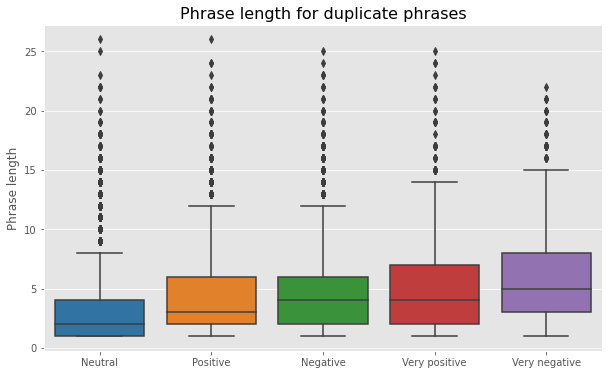

In [8]:
fig, ax = plt.subplots(figsize = (10,6))

sns.boxplot(data=[neutral_lens, pos_lens, neg_lens, very_pos_lens, very_neg_lens])
plt.title('Phrase length for duplicate phrases', fontsize=16)
plt.ylabel('Phrase length')

plt.xticks(ticks=[0, 1, 2, 3, 4], 
           labels=['Neutral', 'Positive', 'Negative', 'Very positive', 'Very negative'],
           rotation=0)

# plt.savefig('phrase_len', dpi=300)

In [9]:
totals = [total_neutral, total_pos, total_neg, total_very_pos, total_very_neg]

In [10]:
dupls = pd.DataFrame({'Total': totals, 'Duplicate': duplicates})

In [11]:
dupls['Total'].sum(), dupls['Duplicate'].sum()

(142410, 65132)

Text(0.5, 0, 'Sentiment')

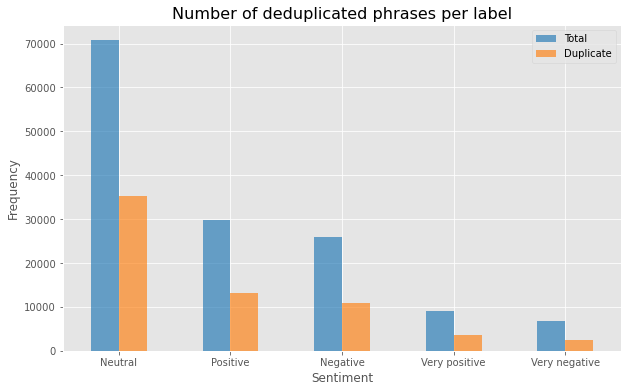

In [12]:
ax = dupls.plot(kind='bar', stacked=False, alpha=0.65, figsize=(10,6))
ax.set_xticklabels(['Neutral', 'Positive', 'Negative', 'Very positive', 'Very negative'], rotation=0)
ax.set_title('Number of deduplicated phrases per label', fontsize=16)
ax.set_ylabel('Frequency')
ax.set_xlabel('Sentiment')

# plt.savefig('dupls', dpi=300)

In [13]:
phrases_to_dedup = []

phrase_count = get_phrase_counts(df)

for k, v in json.loads(Encoder().encode(phrase_count)).items():
    if v['count'] > 1: # Duplicates
        if len(k.split()) > 4:
            if v['label'] == 'Positive':
                phrases_to_dedup.append(k)

In [14]:
phrases_to_dedup[:50]

['yes It like old friend dinner .',
 'Martin Barbara complex characters sometimes tender sometimes angry',
 'Blade II estrogenfree movies get',
 'going make splash even greater Arnold Schwarzenegger JeanClaud Van Damme Steven Segal',
 'become one movies creepiest conventions developmentally disabled',
 'brilliant surfing photography bringing right inside massive waves lifts Blue Crush one summer pleasurable movies',
 'roiling blackandwhite inspires trembling gratitude .',
 'still worthy addition growing canon postSaving Private Ryan tributes greatest generation .',
 'Russell Dreyfus romantic pairing hearts preciously exposed history corners .',
 'picture realizes fullness negate subject .',
 'witness several greekamerican weddings happily',
 'cool event whole family . Maybe classic',
 'kind engaging historical drama Hollywood appears given favor sentimental war movies vein We Were Soldiers',
 'another Best Man clone weaving theme throughout funny film',
 'subtly kinky bedside vigils se

# Label Class Balance

[Text(0, 0, 'Neutral'),
 Text(1, 0, 'Positive'),
 Text(2, 0, 'Negative'),
 Text(3, 0, 'Very positive'),
 Text(4, 0, 'Very negative')]

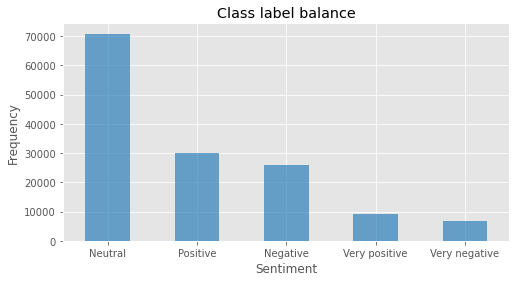

In [15]:
fig, ax = plt.subplots(figsize = (8,4))
ax = df['label'].sort_values(ascending=False).value_counts().plot(kind='bar', alpha=0.65)
ax.set_xlabel('Sentiment')
ax.set_ylabel('Frequency')
ax.set_title('Class label balance')

ax.set_xticklabels(['Neutral', 'Positive', 'Negative', 'Very positive', 'Very negative'], rotation=0)

# Word Count

In [16]:
df['word_count'] = df['phrase_clean'].apply(lambda x: len(str(x).split()))

word_stats = df.groupby('label')['word_count']
word_stats.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Negative,25918.0,5.557528,4.366650,1.0,2.0,4.0,8.0,30.0
Neutral,70779.0,3.272185,3.110194,1.0,1.0,2.0,4.0,28.0
Positive,29852.0,5.139287,4.211864,1.0,2.0,4.0,7.0,29.0
Very negative,6730.0,7.252303,4.920132,1.0,3.0,6.0,10.0,30.0
Very positive,9131.0,6.558646,4.719484,1.0,3.0,5.0,9.0,28.0


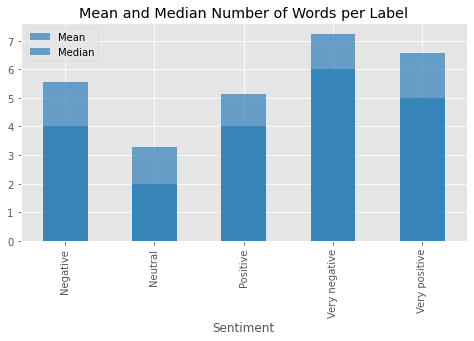

In [17]:
plot_stats(word_stats, xlabel='Sentiment', ylabel='', title='Mean and Median Number of Words per Label')

# Punctuation Count

In [18]:
df['punct_count'] = df['phrase'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation)))

In [19]:
punct_stats = df.groupby('label')['punct_count']
punct_stats.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Negative,25918.0,1.354155,1.879191,0.0,0.0,1.0,2.0,21.0
Neutral,70779.0,0.731658,1.348961,0.0,0.0,0.0,1.0,23.0
Positive,29852.0,1.169101,1.716892,0.0,0.0,1.0,2.0,17.0
Very negative,6730.0,1.972808,2.306826,0.0,0.0,1.0,3.0,22.0
Very positive,9131.0,1.598401,1.983622,0.0,0.0,1.0,2.0,18.0


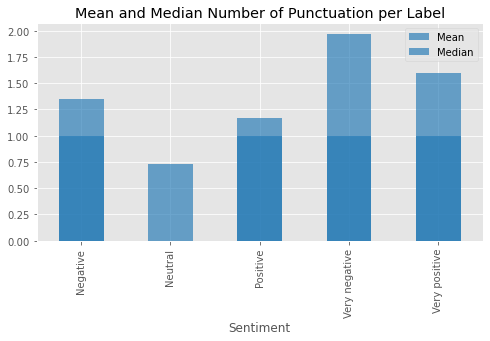

In [20]:
plot_stats(punct_stats, xlabel='Sentiment', ylabel='', title='Mean and Median Number of Punctuation per Label')

- Punctuation occurs more often in in the extreme sentiments.
- Could be a good feature to include in classification to discriminate classes from each other.

# Upper case letter count

In [21]:
df['num_caps'] = df['phrase_clean'].apply(lambda x: sum(1 for c in x if c.isupper()))

In [22]:
numcap_stats = df.groupby('label')['punct_count']
numcap_stats.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Negative,25918.0,1.354155,1.879191,0.0,0.0,1.0,2.0,21.0
Neutral,70779.0,0.731658,1.348961,0.0,0.0,0.0,1.0,23.0
Positive,29852.0,1.169101,1.716892,0.0,0.0,1.0,2.0,17.0
Very negative,6730.0,1.972808,2.306826,0.0,0.0,1.0,3.0,22.0
Very positive,9131.0,1.598401,1.983622,0.0,0.0,1.0,2.0,18.0


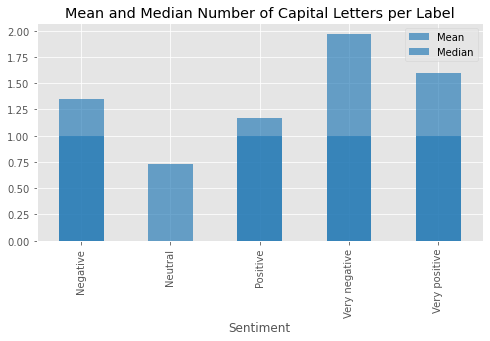

In [23]:
plot_stats(numcap_stats, xlabel='Sentiment', ylabel='', title='Mean and Median Number of Capital Letters per Label')

- Capital letters occur more often in in the extreme sentiments.
- Could be a good feature to include in classification to discriminate classes from each other, as well.

# Density plot of above stats

(-1.0, 20.0)

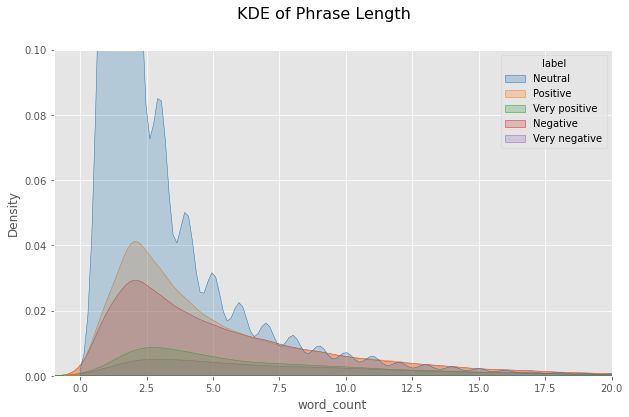

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
fig.suptitle('KDE of Phrase Length', fontsize=16)

labels = df['label'].unique()

ax = sns.kdeplot(data=df, x=df['word_count'], 
                 hue=df['label'], 
                 shade=True)
ax.set_ylim(0, 0.1)
ax.set_xlim(-1, 20)

#plt.savefig('kde', dpi=300)

# LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
train, validate, _ = DataLoader().create_dataframe(preprocess=True, split=True, remove_duplicates=True)

In [ ]:
train.shape

In [ ]:
X_train, y_train = train['phrase_clean'], train['label_id']
X_val, y_val = validate['phrase_clean'], validate['label_id']

In [ ]:
tfidf_vect = TfidfVectorizer(analyzer='word', 
                             max_features=10000, 
                             use_idf=True, 
                             ngram_range=(1,3))

In [ ]:
vect = tfidf_vect.fit(X_train)
X_train_tfidf = vect.transform(X_train)
X_val_tfidf = vect.transform(X_val)

In [ ]:
X_train_tfidf.shape

In [ ]:
X_dense = X_train_tfidf.toarray()

lda = LinearDiscriminantAnalysis(n_components=None)
X_lda = lda.fit(X_dense, y_train)

In [ ]:
lda_var_ratios = lda.explained_variance_ratio_

In [ ]:
lda_var_ratios

In [ ]:
lda.explained_variance_ratio_

In [ ]:
select_n_components(lda_var_ratios, 0.95)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(lda.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('LDA Cumulative Explained Variance', fontsize=16)
plt.savefig('lda', dpi=300)

In [ ]:
lda_2 = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda_2.fit(X_dense, y_train).transform(X_dense)

In [ ]:
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=train['label_id'], 
            edgecolor='none', 
            alpha=0.25, 
            cmap=plt.get_cmap('Spectral', 10))

plt.colorbar()
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.title('2D LDA Plot of TF-IDF input vectors', fontsize=16)
plt.savefig('lda-2d', dpi=300)